In [264]:
import pandas as pd
import os
import matplotlib.pyplot as plt

dir = './dylans_spotify'
all_data = []

for file in os.listdir(dir):
    if file.endswith('.json') and 'Audio' in file:
        print(file)
        df = pd.read_json(os.path.join(dir, file))
        all_data.append(df)

df = pd.concat(all_data, ignore_index=True)

show_labels = True

Streaming_History_Audio_2021-2022_2.json
Streaming_History_Audio_2020-2021_1.json
Streaming_History_Audio_2022-2023_3.json
Streaming_History_Audio_2023-2024_4.json
Streaming_History_Audio_2024-2025_5.json
Streaming_History_Audio_2019-2020_0.json


In [265]:
df = df[['ts', 'platform', 'ms_played', 'conn_country', 'ip_addr',
       'master_metadata_track_name', 'master_metadata_album_artist_name',
       'master_metadata_album_album_name', 'spotify_track_uri',
       'reason_start', 'reason_end', 'shuffle', 'skipped', 'offline',
       'offline_timestamp', 'incognito_mode']]
df.columns = ['ts', 'platform', 'ms_played', 'conn_country', 'ip_addr',
       'track', 'artist', 'album', 'spotify_track_uri',
       'reason_start', 'reason_end', 'shuffle', 'skipped', 'offline',
       'offline_timestamp', 'incognito_mode']
df = df[df['artist'] != 'Adam Gent']
df['minutes'] = df['ms_played']/1000/60
df['ts'] = pd.to_datetime(df['ts'])

# Extract year and month
df['year'] = df['ts'].dt.year
df['month'] = df['ts'].dt.month

/var/folders/vb/c_7gcdvd2kg4s_jdwfky3xhm0000gn/T/ipykernel_77157/4012951350.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['ts'].dt.to_period('M')


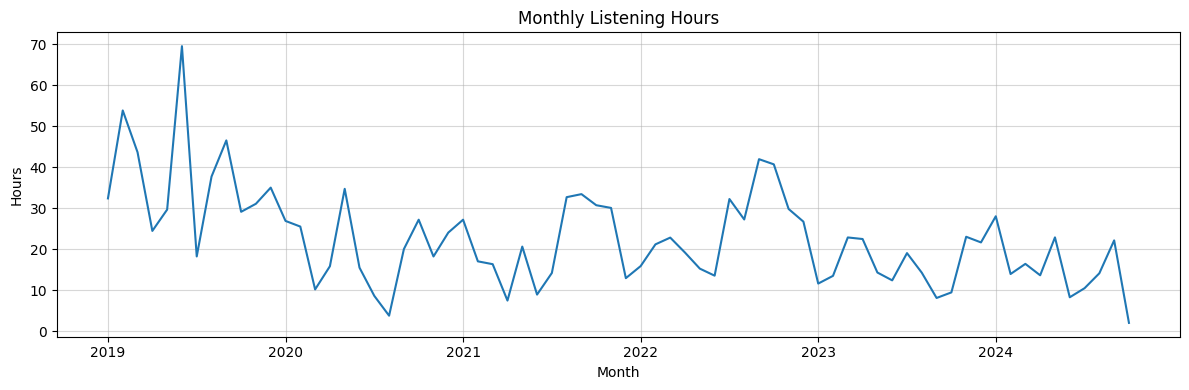

In [266]:
df['year_month'] = df['ts'].dt.to_period('M')

monthly_listening = df.groupby('year_month')['ms_played'].sum()
gd_monthly = df[df['artist'] == 'Grateful Dead'].groupby('year_month')['ms_played'].sum()
monthly_hours = monthly_listening / (1000 * 60 * 60)
gd_monthly_hours = gd_monthly / (1000 * 60 * 60)

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(monthly_hours.index.astype(str), monthly_hours.values)
# ax.plot(gd_monthly_hours.index.astype(str), gd_monthly_hours.values)

ax.set_title('Monthly Listening Hours')

tick_positions = range(0, len(monthly_hours), 12)
ax.set_xticks(tick_positions)
ax.set_xticklabels([monthly_hours.index.astype(str)[i][:4] for i in tick_positions])

ax.set_xlabel('Month')
ax.set_ylabel('Hours')
ax.grid(alpha=0.5)
plt.tight_layout()
plt.show()

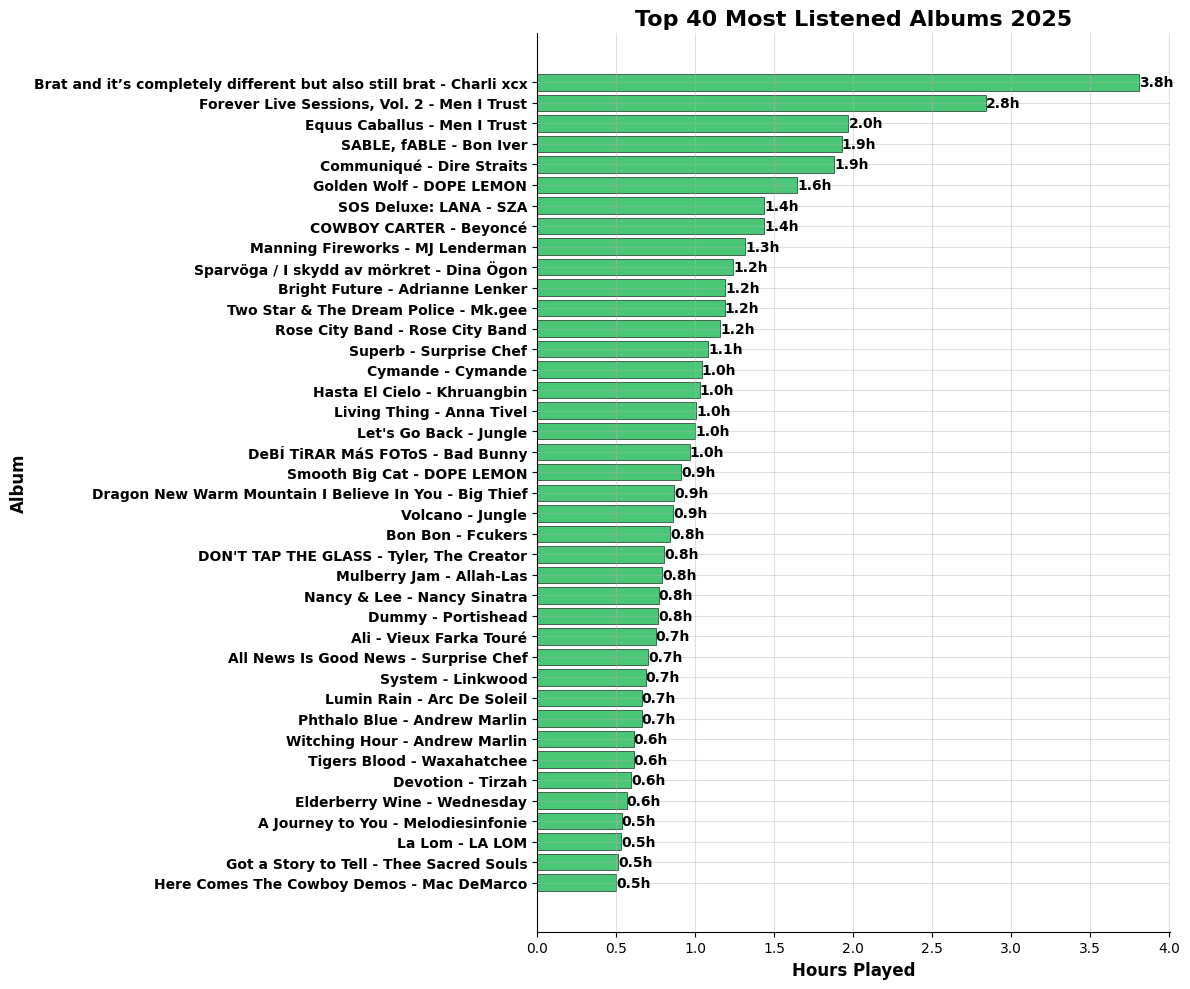

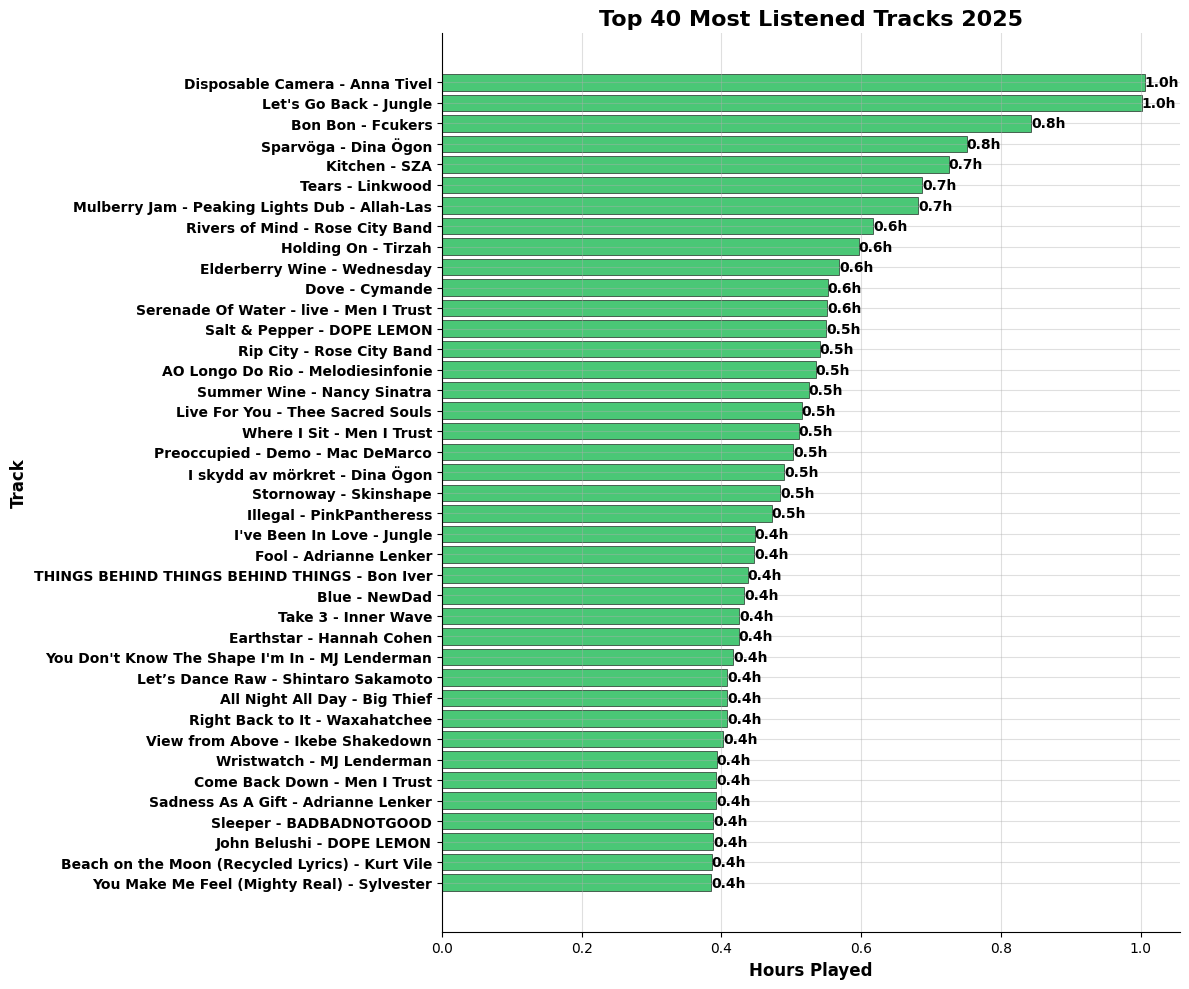

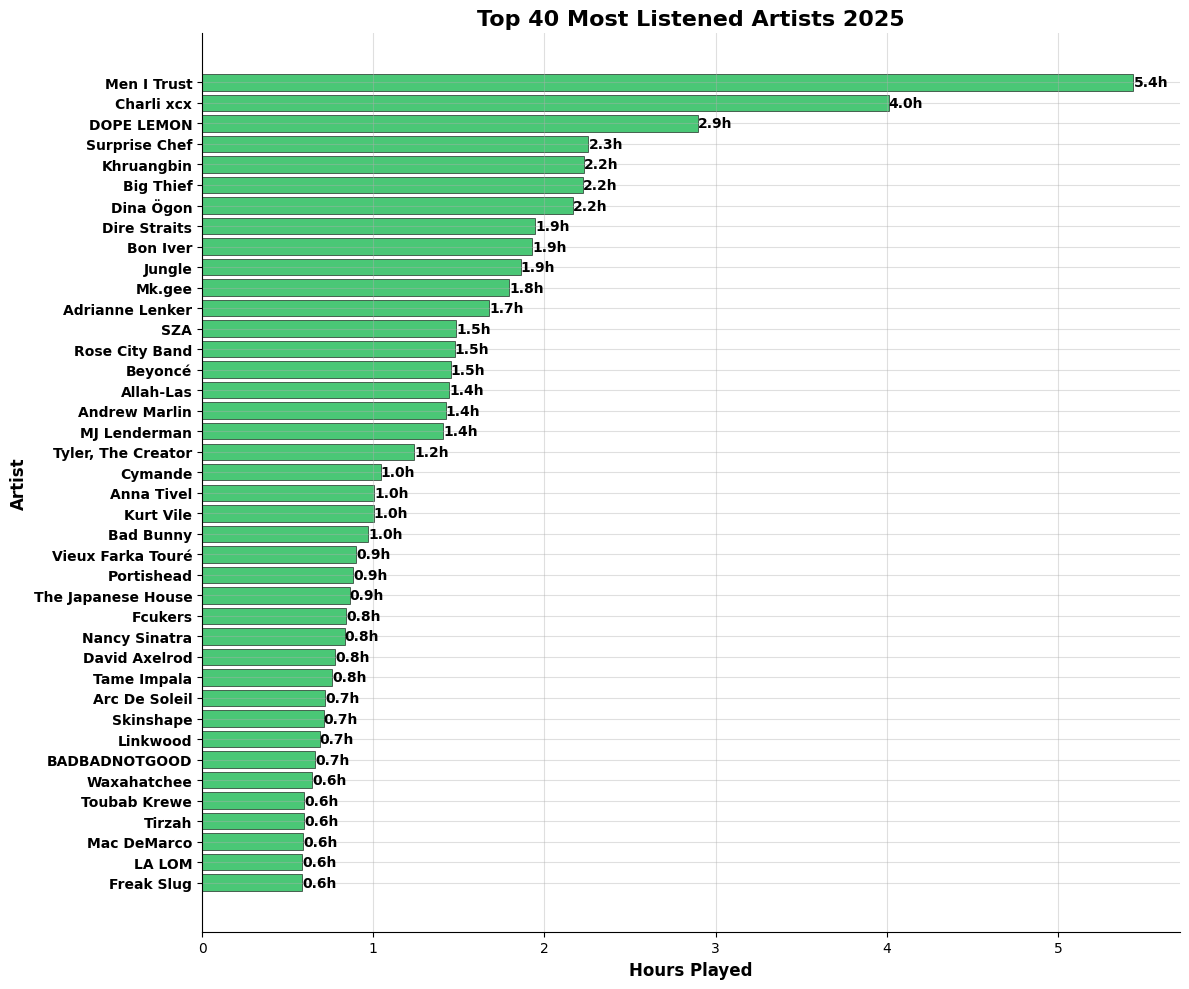

In [276]:
def most_popular_x(df, x, n=20, year='Alltime', show_labels = show_labels):
    """x = 'track', 'artist', or 'album' """
    if year != 'Alltime':
        df = df[df['year'] == year]
    
    if x == 'artist':
        xdf = df.groupby(x)['ms_played'].sum().sort_values(ascending=False).reset_index()
        # For artists, just use the artist name
        labels = xdf[x][:n][::-1]
    else:
        xdf = df.groupby([x,'artist'])['ms_played'].sum().sort_values(ascending=False).reset_index()
        # For tracks/albums, combine with artist name
        labels = [f"{row[x]} - {row['artist']}" for _, row in xdf[:n][::-1].iterrows()]
    
    xdf['hours'] = xdf['ms_played']/1000/60/60
    
    fig, ax = plt.subplots(figsize=(12, 10))
    bars = ax.barh(range(n), xdf['hours'][:n][::-1],
                   color='#1DB954', alpha=0.8, edgecolor='black', linewidth=0.5)
    
    ax.set_title(f'Top {n} Most Listened {x.title()}s {year}', fontsize=16, fontweight='bold')
    ax.set_xlabel('Hours Played', fontsize=12, fontweight='bold')


    if show_labels:
        ax.set_ylabel(x.title(), fontsize=12, fontweight='bold')
        ax.set_yticks(range(n))
        ax.set_yticklabels(labels, fontweight='bold')
    else:
        ax.set_yticks([])  # Remove all y-ticks
        ax.set_yticklabels([])  # Remove all y-tick labels

        
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2,
                f'{width:.1f}h', ha='left', va='center', fontweight='bold')
    
    plt.tight_layout()
    ax.grid(alpha=.4)
    plt.show()
year = 2025
most_popular_x(df, 'album',year=year, n = 40, show_labels=show_labels)
most_popular_x(df, 'track',year=year, n=40, show_labels=show_labels)
most_popular_x(df, 'artist',year=year, n=40, show_labels=show_labels)

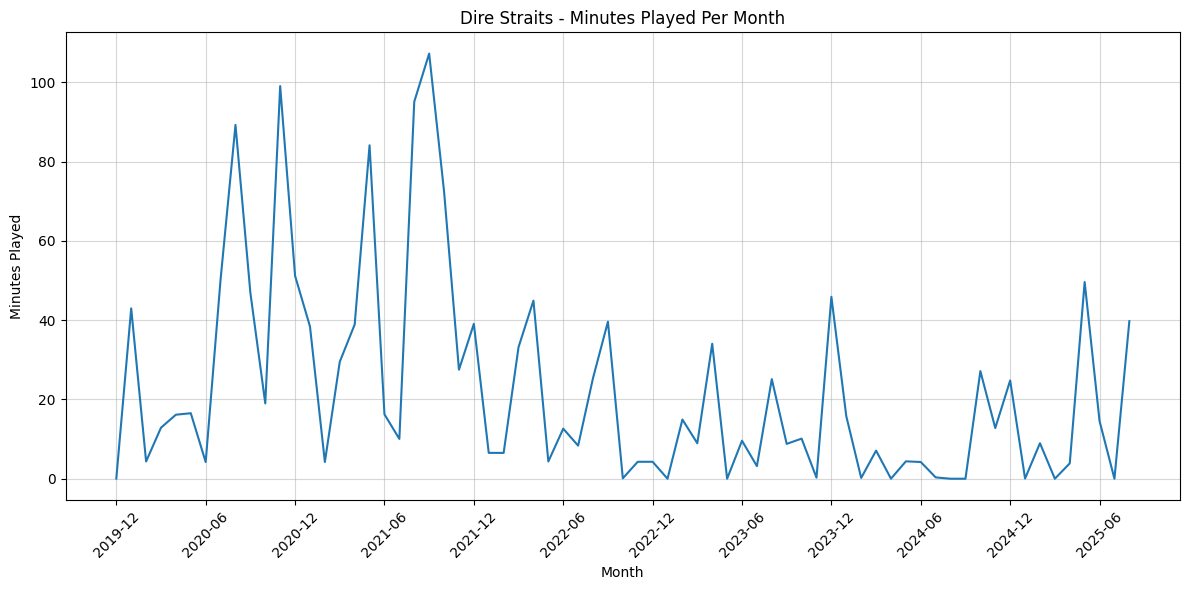

In [268]:
def plot_artist_minutes_per_month(df, show_band):
    mystery_band = 'Dire Straits'
    df_filtered = df[df['artist'] == mystery_band]
    artist_plays_per_mo = df_filtered.groupby('year_month')['ms_played'].sum()
    
    full_date_range = pd.period_range(
        start=df_filtered['year_month'].min(),
        end=df_filtered['year_month'].max(),
        freq='M'
    )
    
    artist_plays_per_mo = artist_plays_per_mo.reindex(full_date_range, fill_value=0)
    
    # Convert to minutes and add proper labels
    artist_minutes_per_mo = artist_plays_per_mo / (1000 * 60)
    
    fig, ax = plt.subplots(figsize=(12, 6))  # Made it wider for better time series viewing
    ax.plot(artist_minutes_per_mo.index.astype(str), artist_minutes_per_mo.values)
    if show_band:
        ax.set_title(f'{mystery_band} - Minutes Played Per Month')
    else:
        ax.set_title(f'Mystery Band - Minutes Played Per Month')
    ax.set_xlabel('Month')
    ax.set_ylabel('Minutes Played')
    
    # Show fewer x-axis labels for cleaner look
    tick_positions = range(0, len(artist_minutes_per_mo), 6)  # Every 6 months
    ax.set_xticks(tick_positions)
    ax.set_xticklabels([artist_minutes_per_mo.index.astype(str)[i] for i in tick_positions])
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    ax.grid(alpha=0.5)
    plt.show()

plot_artist_minutes_per_month(df, show_band = True)

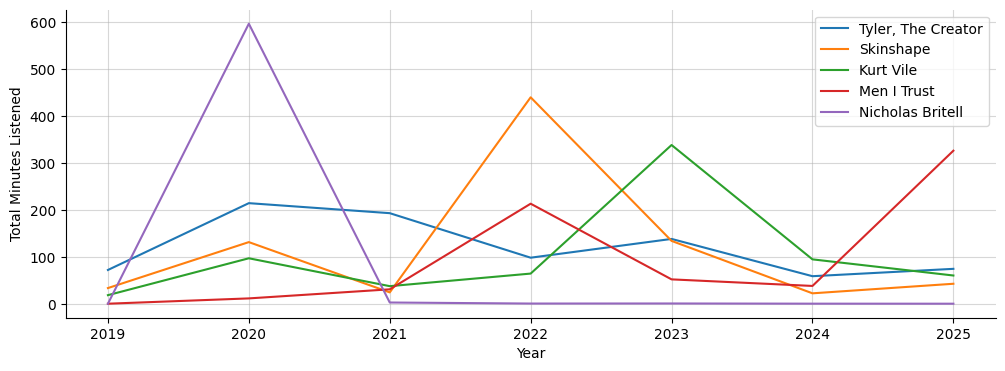

In [269]:
def plot_top_artists_minutes_per_year(df, n=5, page=1, show_labels=True, artists_to_include = []):
    artists = df.groupby('artist')['ms_played'].sum().sort_values(ascending=False).reset_index()
    df = df[df['year'].astype(int) > 2014]
    top_artists = artists['artist'].values[:1000]
    top_artists_df = df[df['artist'].isin(top_artists)]
    artist_minutes_by_year = top_artists_df.groupby(['year', 'artist'])['minutes'].sum().sort_values(ascending=False).reset_index().sort_values('year')
    artists_minutes_per_year = artist_minutes_by_year.pivot(columns='artist', index='year', values='minutes').fillna(0)
    fig, ax = plt.subplots(figsize=(12,4))
    upper_bound = n * page
    lower_bound = upper_bound - n
    for artist in top_artists[lower_bound: upper_bound]:
        ax.plot(artists_minutes_per_year[artist], label=artist)
    if show_labels:
        ax.legend()
    ax.set_xlabel('Year')
    ax.set_ylabel('Total Minutes Listened')
    ax.grid(alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    guess = 'Dina Ögon'
    guess = 'Mac DeMarco'
    guess = "Dire Straits"
    guess = 'Tyler, The Creator'
    guess = "Skinshape"
    guess = 'Big Thief'
    # ax.plot(artists_minutes_per_year[guess], label=guess, c='black')
    # ax.plot(artists_minutes_per_year['Jack Johnson'], label='Jack Johnson')

plot_top_artists_minutes_per_year(df, n = 5, page=3, show_labels=True)

In [270]:
# how often do you actually listen to a new artist? 
split = 2022
df = df.sort_values('ts')
before = df[df['year'].astype(int) < split]
after = df[df['year'].astype(int) >=split]

before_artists = set(before['artist'])
artists = after.groupby('artist')['minutes'].sum().sort_values(ascending=False).reset_index()

new_artists = artists[~artists['artist'].isin(before_artists)]

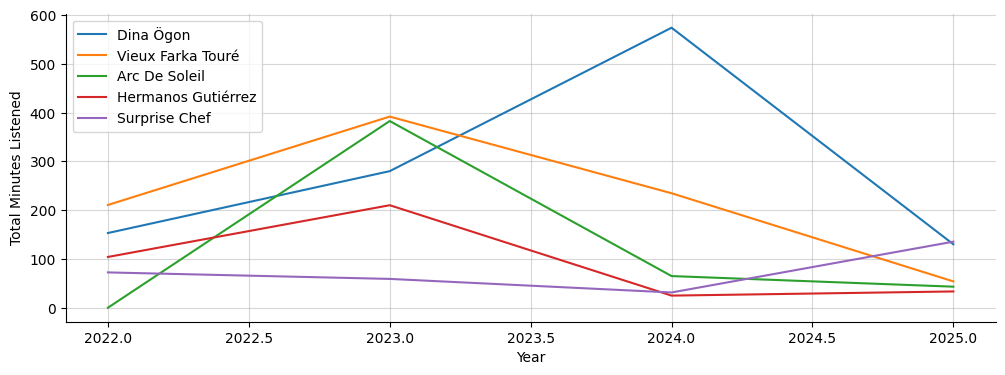

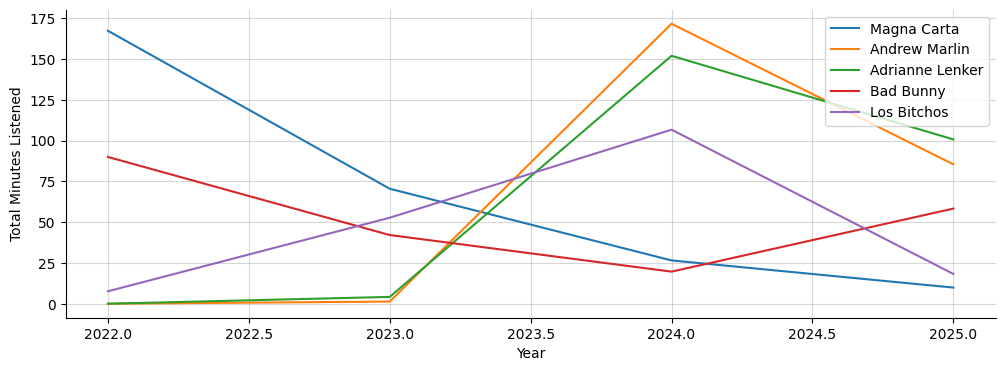

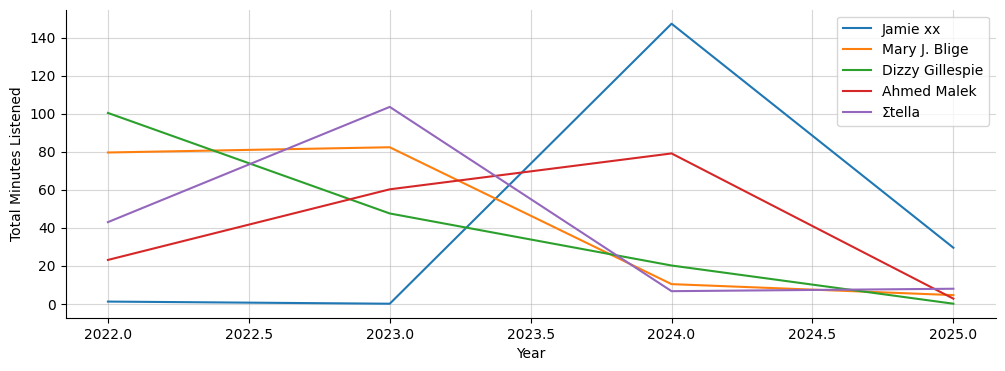

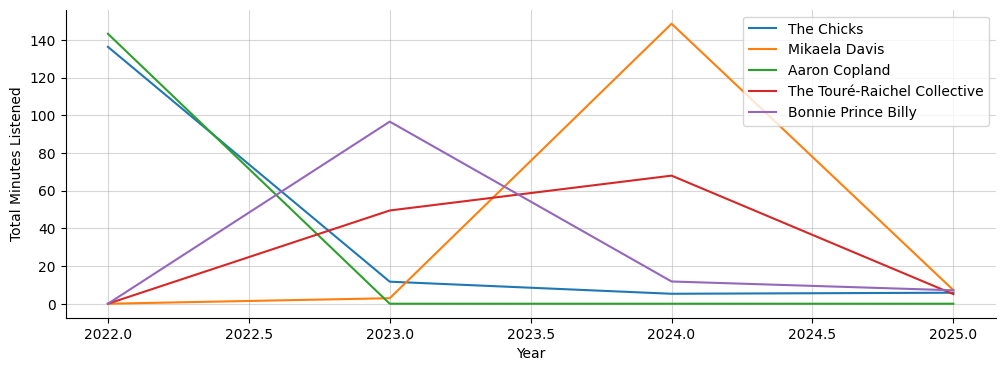

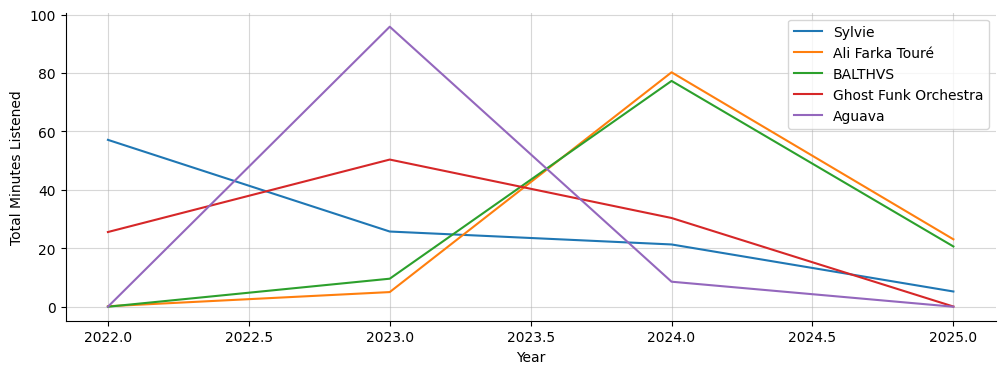

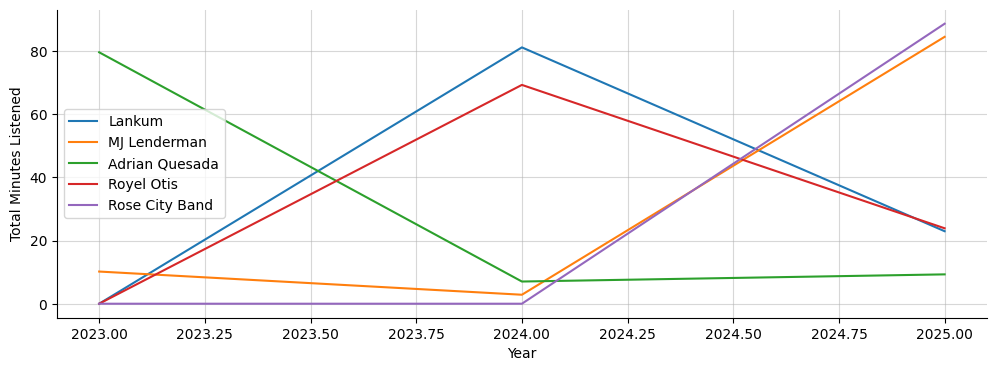

In [271]:
def artist_minutes_by_year(df, artists: list, show_labels=show_labels):
    df = df[df['artist'].isin(artists)]
    temp = df.groupby(['year', 'artist'])['minutes'].sum().sort_values(ascending=False).reset_index().sort_values('year')
    temp2 = temp.pivot(columns='artist', index='year', values='minutes').fillna(0)
    
    fig, ax = plt.subplots(figsize=(12,4))
    for artist in artists:
        if artist == 'Joey Bada$$':
            artist_label = 'Joey Bada\$\$'
        else:
            artist_label = artist
        ax.plot(temp2[artist], label=artist_label)
    if show_labels:
        ax.legend()
    ax.set_xlabel('Year')
    ax.set_ylabel('Total Minutes Listened')
    ax.grid(alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Remove plt.show() from here
    return fig, ax

# Then call it like this:
for i in range(0, 30, 5):
    fig, ax = artist_minutes_by_year(df, new_artists['artist'][i:i+5].values, show_labels = True)
    plt.show() 

In [272]:
# a viz of a bar chart being made over time of your most popular artists and you can see when new artists come and you listened to them for a little while
# and you can see your favorite artists just stacking up listens over time

In [273]:
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# import pandas as pd
# import numpy as np

# def create_artist_bar_race(df, top_n=15, time_period='month'):
#     # Create hours column if it doesn't exist
#     if 'hours' not in df.columns:
#         if 'ms_played' in df.columns:
#             df = df.copy()
#             df['hours'] = df['ms_played'] / 1000 / 60 / 60
#         elif 'minutes' in df.columns:
#             df = df.copy()
#             df['hours'] = df['minutes'] / 60
    
#     # Create time period column
#     df = df.copy()
#     df['ts'] = pd.to_datetime(df['ts'])
    
#     if time_period == 'week':
#         df['time_period'] = df['ts'].dt.to_period('W').astype(str)
#     elif time_period == 'month':
#         df['time_period'] = df['ts'].dt.to_period('M').astype(str)
#     else:  # year
#         df['time_period'] = df['year'].astype(str)
    
#     # Prepare cumulative data by time period
#     df_period = df.groupby(['time_period', 'artist'])['hours'].sum().reset_index()
    
#     # Get all time periods and artists
#     time_periods = sorted(df_period['time_period'].unique())
#     all_artists = df_period['artist'].unique()
    
#     # Create cumulative data
#     cumulative_data = []
#     for period in time_periods:
#         period_data = df_period[df_period['time_period'] <= period].groupby('artist')['hours'].sum().reset_index()
#         period_data['time_period'] = period
#         cumulative_data.append(period_data)
    
#     cumulative_df = pd.concat(cumulative_data)
    
#     # Get top artists overall to focus animation
#     top_artists = cumulative_df.groupby('artist')['hours'].max().sort_values(ascending=False).head(top_n * 2).index
    
#     fig, ax = plt.subplots(figsize=(16, 10))
    
#     def animate(period_idx):
#         ax.clear()
#         current_period = time_periods[period_idx]
        
#         # Get data for current period
#         current_data = cumulative_df[
#             (cumulative_df['time_period'] == current_period) & 
#             (cumulative_df['artist'].isin(top_artists))
#         ].sort_values('hours', ascending=False).head(top_n)
        
#         # Create horizontal bars
#         bars = ax.barh(range(len(current_data)), current_data['hours'], 
#                       color='#1DB954', alpha=0.8, edgecolor='black', linewidth=0.5)
        
#         # Set labels with better spacing
#         ax.set_yticks(range(len(current_data)))
#         ax.set_yticklabels(current_data['artist'], fontweight='bold', fontsize=10)
#         ax.set_xlabel('Cumulative Hours Played', fontsize=12, fontweight='bold')
        
#         period_label = time_period.capitalize()
#         ax.set_title(f'Top {top_n} Artists - Cumulative Listening Time\n{period_label}: {current_period}', 
#                     fontsize=16, fontweight='bold', pad=20)
        
#         # Add value labels on bars
#         for i, (bar, hours) in enumerate(zip(bars, current_data['hours'])):
#             ax.text(bar.get_width() + max(current_data['hours']) * 0.01, 
#                    bar.get_y() + bar.get_height()/2,
#                    f'{hours:.0f}h', ha='left', va='center', fontweight='bold')
        
#         # Style
#         ax.spines['top'].set_visible(False)
#         ax.spines['right'].set_visible(False)
#         ax.set_xlim(0, max(current_data['hours']) * 1.2)
#         ax.invert_yaxis()
        
#         # Adjust layout to prevent label cutoff
#         plt.subplots_adjust(left=0.25, right=0.95, top=0.9, bottom=0.1)
    
#     # Create animation with faster interval for more frequent updates
#     interval = 200 if time_period == 'week' else 400 if time_period == 'month' else 800
#     anim = animation.FuncAnimation(fig, animate, frames=len(time_periods), 
#                                   interval=interval, repeat=True, blit=False)
    
#     return anim

# # Usage:
# # Enable interactive plotting for animations
# %matplotlib notebook
# # or try: %matplotlib widget

# anim = create_artist_bar_race(df)
# plt.show()

# # If animation still doesn't work in notebook, save as HTML:
# # anim.save('spotify_bar_race.html', writer='html', fps=1.5)

# # To save as gif:
# anim.save('spotify_bar_race.gif', writer='pillow', fps=1.5)